# Libraries:

In [85]:
import polars as pl # Memory? What is that? We borrow.
import pandas as pd # Pandas for some of the libraries that doesn't support polars.
import matplotlib.pyplot as plt # For visualizing.
import math # For the built in math functions.
import seaborn as sns # For visualizing.
import numpy as np # For linear algebra.
import pandas_market_calendars as mcal # For accurate trading days.
from pandas.plotting import autocorrelation_plot # ACF plot.
import time

from scipy import stats # Statistics
from scipy.stats import boxcox # Box-Cox transformation.

# For scoring.
from sklearn.metrics import mean_squared_error

# For seasonal unit root testing.
from pmdarima.arima import OCSBTest, CHTest

# Statsmodels for statistical analysis and forecasting.
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_lm
from statsmodels.datasets import get_rdataset

from jormund import * # Personal library.
setup_plots() # To make the graphs look better.

import gc # garbage collection.

# To ignore the annoying warnings.
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

%matplotlib inline

# Time Series data:

In [15]:
# the get_rdataset() function can't get the jj_ts data
# jj_ts = get_rdataset("jj_ts", "timeSeriesDataSets")

quartely_earnings_per_share = [
    0.71, 0.63, 0.85, 0.44,    # 1960
    0.61, 0.69, 0.92, 0.55,    # 1961
    0.72, 0.77, 0.92, 0.60,    # 1962
    0.83, 0.80, 1.00, 0.77,    # 1963
    0.92, 1.00, 1.24, 1.00,    # 1964
    1.16, 1.30, 1.45, 1.25,    # 1965
    1.26, 1.38, 1.86, 1.56,    # 1966
    1.53, 1.59, 1.83, 1.86,    # 1967
    1.53, 2.07, 2.34, 2.25,    # 1968
    2.16, 2.43, 2.70, 2.25,    # 1969
    2.79, 3.42, 3.69, 3.60,    # 1970
    3.60, 4.32, 4.32, 4.05,    # 1971
    4.86, 5.04, 5.04, 4.41,    # 1972
    5.58, 5.85, 6.57, 5.31,    # 1973
    6.03, 6.39, 6.93, 5.85,    # 1974
    6.93, 7.74, 7.83, 6.12,    # 1975
    7.74, 8.91, 8.28, 6.84,    # 1976
    9.54, 10.26, 9.54, 8.73,   # 1977
    11.88, 12.06, 12.15, 8.91, # 1978
    14.04, 12.96, 14.85, 9.99, # 1979
    16.20, 14.67, 16.02, 11.61 # 1980
]

year_index = np.arange(1960, 1981)
time_index = []

for year in year_index:
    for quarter in range(4):
        month = (quarter + 1) * 3
        time_index.append(f'{year}-{month:02d}-01')  # YYYY-MM-DD format

date = pl.Series(
    "date",
    time_index,
    dtype=pl.Date  # or pl.Datetime for timestamps
).str.strptime(pl.Date, "%Y-%m-%d")

jj_ts_dict = {
    'price': quartely_earnings_per_share,
    'date': date
}

jj_ts = pl.DataFrame(jj_ts_dict)

In [121]:
train = jj_ts[:-8]
test = jj_ts[-8:]

# Functions:

In [47]:
def test_unit_roots(data, series, lags):
    plot_rolling_statistics(data, series, window=4)
    acf_pacf(data, series, lags, alpha=0.05)

    adf_results(data, series)
    kpss_results(data, series)
    seasonal_unit_root(data, series)

In [17]:
def kpss_results(data, series):
    for r in ["c", "ct"]:
        kpss_result = kpss(data[series], regression='c', nlags="auto")
        
        print(f'KPSS Test: {r}')
        print(f'KPSS Statistic: {kpss_result[0]}')
        print(f'p-value: {kpss_result[1]} \n')

In [18]:
def adf_results(data, series):
    for r in ["c", "ct"]:
        adf_result = adfuller(data[series], regression=r, autolag='BIC')
    
        print(f'Augmented Dickey-Fuller Test: {r}')
        print(f'ADF Statistic: {adf_result[0]}')
        print(f'p-value: {adf_result[1]} \n')

In [27]:
def seasonal_unit_root(data, series):
    n_ocsb = OCSBTest(m=12).estimate_seasonal_differencing_term(data[series])
    n_ch = CHTest(m=12).estimate_seasonal_differencing_term(data[series])
    
    n_seasdiffs = {"recommended order of seasonal differencing":"", "   OCSB recommendation":n_ocsb, "    nCH recommendation":n_ch}
    [print(key, ":", value) for key,value in n_seasdiffs.items()]

In [45]:
def acf_pacf(data, series, lags, alpha=0.05):
    plot_acf(data[series], lags=lags, alpha=alpha)
    plt.xlabel('Lags', fontsize=12)
    plt.ylabel('AC', fontsize=12)
    plt.tight_layout()
    plot_pacf(data[series], lags=lags, alpha=alpha)
    plt.xlabel('Lags', fontsize=12)
    plt.ylabel('PAC', fontsize=12)
    plt.tight_layout()
    plt.show()

In [21]:
def time_series_plot(data, series):
    plt.figure(figsize=(11, 4))
    plt.plot(data['date'], data[series])
    plt.tight_layout()
    plt.show()

In [44]:
def plot_rolling_statistics(data, series, window=4):
    rolling_mean = data[series].to_pandas().rolling(window=window).mean()
    rolling_std = data[series].to_pandas().rolling(window=window).std()
    
    plt.figure(figsize=(11, 4))
    plt.plot(data['date'], data[series], label='Original Series')
    plt.plot(data['date'], rolling_mean, label='Rolling Mean')
    plt.plot(data['date'], rolling_std, label='Rolling Std')
    plt.legend(loc="upper left")
    plt.title("Time Series & Its's rolling properties")
    plt.tight_layout()
    plt.show()

In [60]:
def model_summary(data, order, seasonal_order, trend):
    t1 = time.time()
    model = SARIMAX(endog=data, order=order, seasonal_order=seasonal_order, trend=trend, mle_regression=False)
    results = model.fit(method='powell', disp=False)
    print(results.summary())
    t2 = time.time()
    print('Elapsed time [m]: ', np.round((t2-t1)/60,4))
    gc.collect()

# Visualization:

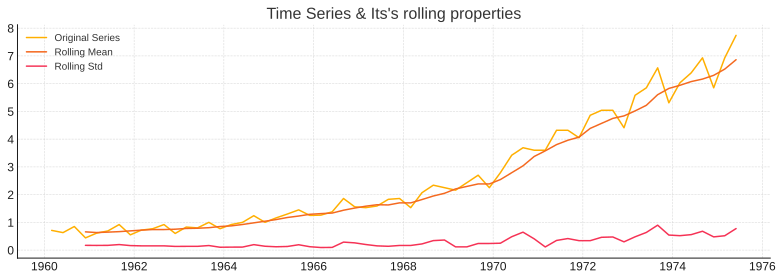

In [23]:
plot_rolling_statistics(train, 'price', 4) # window=4 for the change in each year.

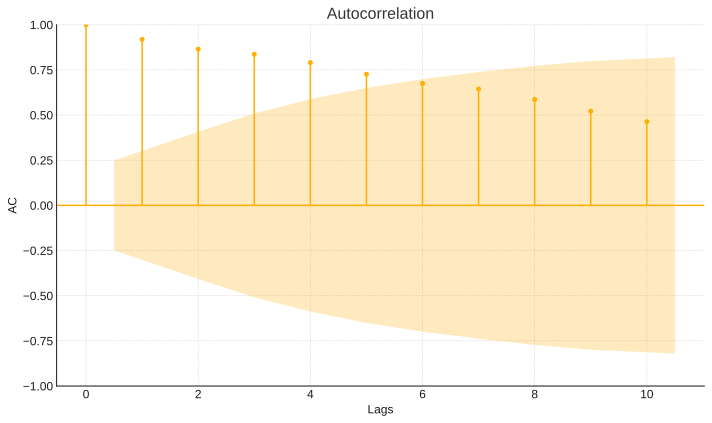

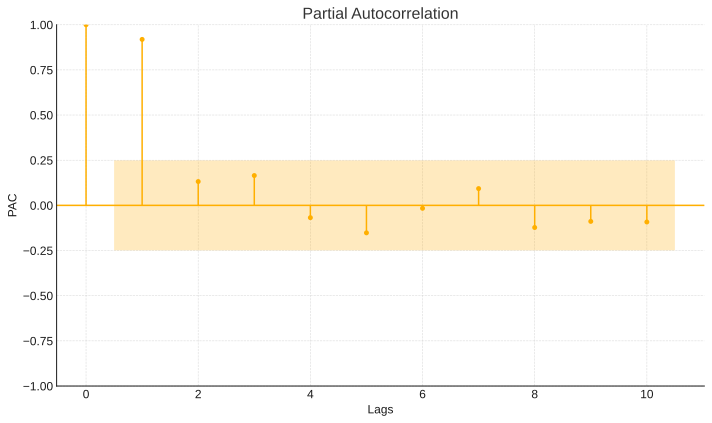

In [24]:
acf_pacf(train, 'price', 10, 10)

- There seems to be seasonality, trend, and heteroscadasticity(We need to test the data using the ARCH test and also compare the IC scores to make sure there is heteroscadasticity.) by looking at the time series plot and its rolling properties.
- The non-stationarity is confirmed by the ACF plot.
- The seasonal trend seems to be visible from the ACF plot but it is quite hard to tell so we will need to do seasonal unit root tests to be sure.

# Unit Root testing:

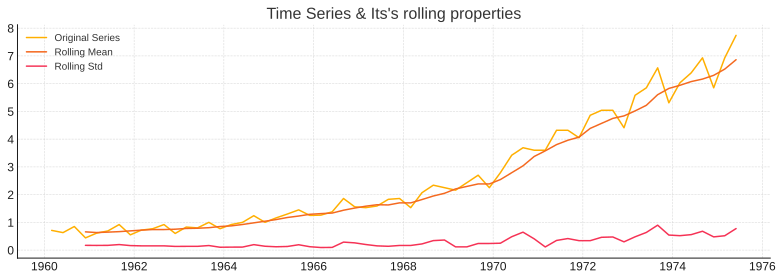

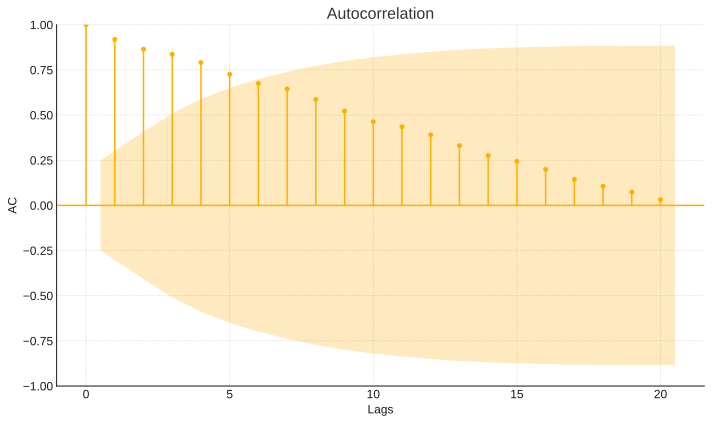

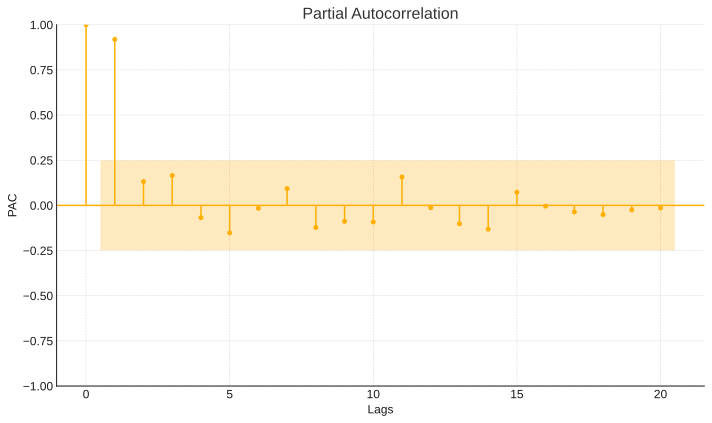

Augmented Dickey-Fuller Test: c
ADF Statistic: 3.145321600334948
p-value: 1.0 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -0.06981101550199299
p-value: 0.9934534962041947 

KPSS Test: c
KPSS Statistic: 1.0459661175554598
p-value: 0.01 

KPSS Test: ct
KPSS Statistic: 1.0459661175554598
p-value: 0.01 

recommended order of seasonal differencing : 
   OCSB recommendation : 1
    nCH recommendation : 0


In [49]:
test_unit_roots(train, 'price', 20)

- From ADF and KPSS test, it is clear that the data has a stochastic trend.
- From OSCB and CH, we can't tell for sure that there is a seasonal trend.
- For the Seasonal unit root we need to do try the data with a seasonal difference.

## Differencing:

In [53]:
train = train.with_columns([
    pl.col('price').diff().alias('price_diff'),
    pl.col('price').diff(4).alias('price_seasonal_diff'),
    pl.col('price').diff(4).diff().alias('price_sdiff_diff'),
    pl.col('price').diff().diff().alias('price_diff_diff'),
    pl.col('price').diff(4).diff().diff().alias('price_sdiff_diff_diff'),
])

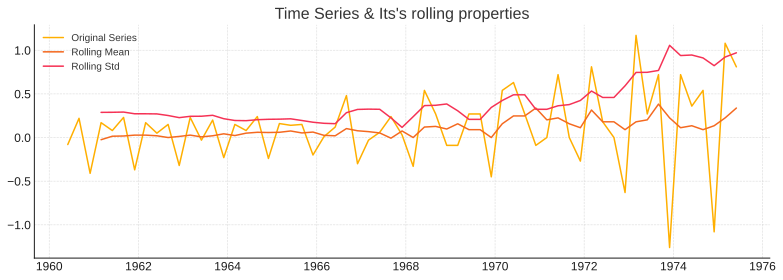

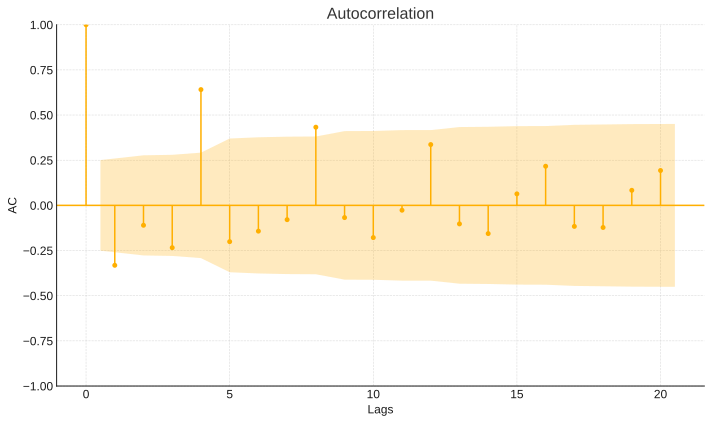

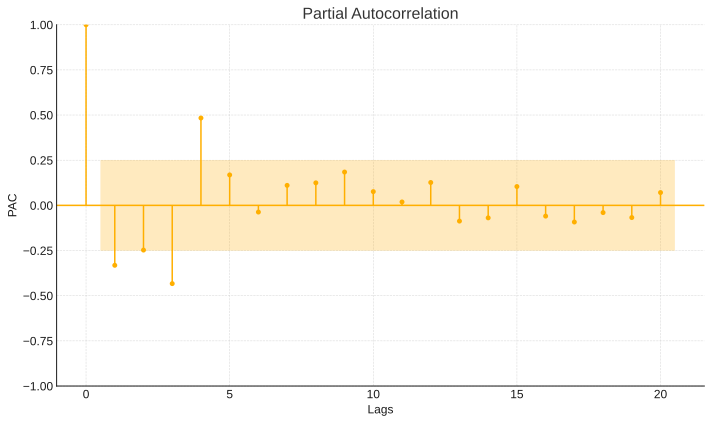

Augmented Dickey-Fuller Test: c
ADF Statistic: -2.6675592520856592
p-value: 0.07982211979941145 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -14.430641177547422
p-value: 4.886381773974819e-22 

KPSS Test: c
KPSS Statistic: 0.43139516368606196
p-value: 0.06362277427324917 

KPSS Test: ct
KPSS Statistic: 0.43139516368606196
p-value: 0.06362277427324917 

recommended order of seasonal differencing : 
   OCSB recommendation : 1
    nCH recommendation : 0


In [50]:
test_unit_roots(train[1:], 'price_diff', 20)

### Regular difference:

- Time series plot: Differenced data has seasonality, trend and heteroscadasticity.
- ACF & PACF: The data is stationary, but seasonal trend is questionable.
- ADF: There is a deterministic trend.
- KPSS: The data is stationary.
- OCSB & CH: The seasonal unit root still needs to be investigated.

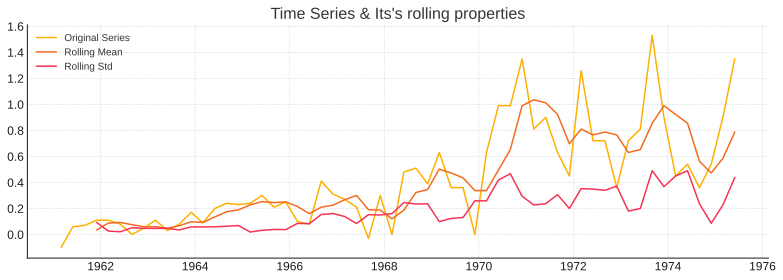

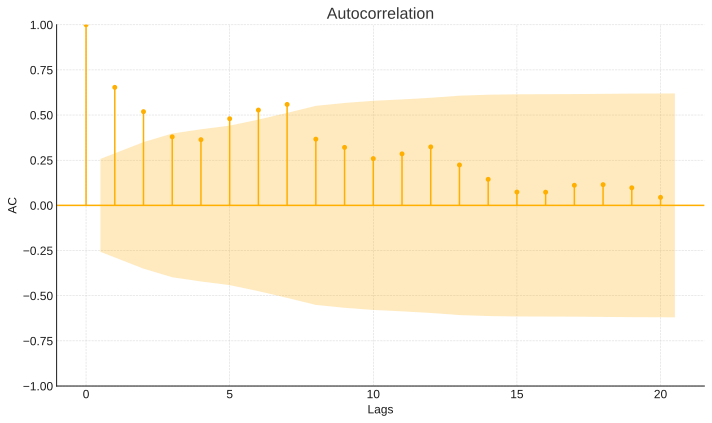

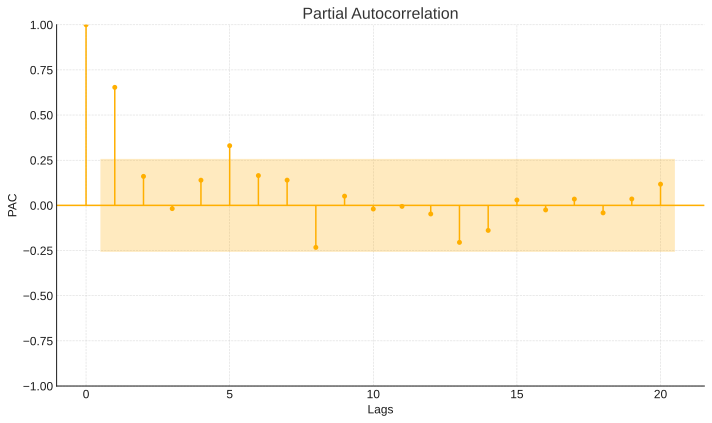

Augmented Dickey-Fuller Test: c
ADF Statistic: -2.7307497036185735
p-value: 0.06886669427827896 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -4.860602489068942
p-value: 0.00036631244848648985 

KPSS Test: c
KPSS Statistic: 1.0945695201329573
p-value: 0.01 

KPSS Test: ct
KPSS Statistic: 1.0945695201329573
p-value: 0.01 

recommended order of seasonal differencing : 
   OCSB recommendation : 0
    nCH recommendation : 0


In [51]:
test_unit_roots(train[4:], 'price_seasonal_diff', 20)

### Seasonal difference:

- Time series plot: Differenced data is seasonality, trend and heteroscadasticity.
- ACF & PACF: The data is not stationary, but no seasonal trend.
- ADF: There is a deterministic trend.
- KPSS: The data is not stationary, there is a stochastic trend.
- OCSB & CH: no seasonal unit root.

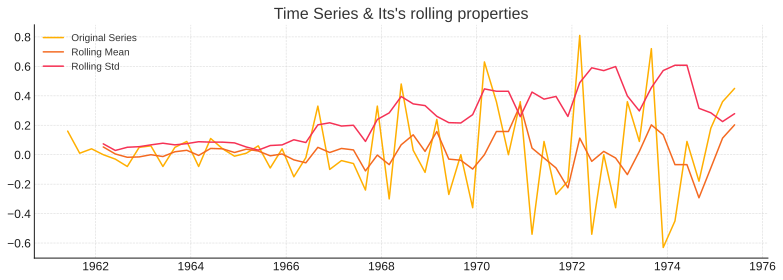

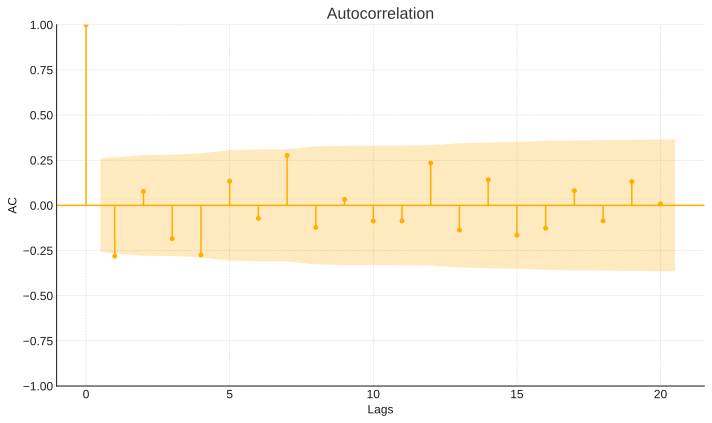

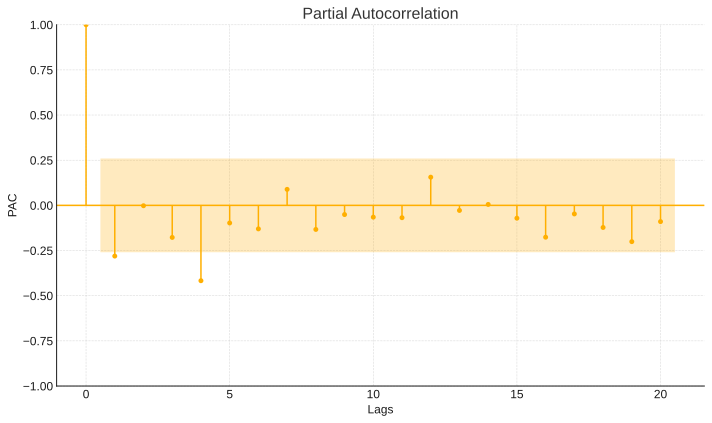

Augmented Dickey-Fuller Test: c
ADF Statistic: -6.73954243215677
p-value: 3.1443112233885536e-09 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -6.6369974458149565
p-value: 9.198225696810341e-08 

KPSS Test: c
KPSS Statistic: 0.03896570448370258
p-value: 0.1 

KPSS Test: ct
KPSS Statistic: 0.03896570448370258
p-value: 0.1 

recommended order of seasonal differencing : 
   OCSB recommendation : 0
    nCH recommendation : 0


In [52]:
test_unit_roots(train[5:], 'price_sdiff_diff', 20)

### Seasonal difference and a regular difference:

- Time series plot: Differenced data is seasonality, trend and heteroscadasticity.
- ACF & PACF: The data is not stationary, but no seasonal trend.
- ADF: The data is stationary.
- KPSS: The data is not stationary, there is a stochastic trend.
- OCSB & CH: no seasonal unit root.

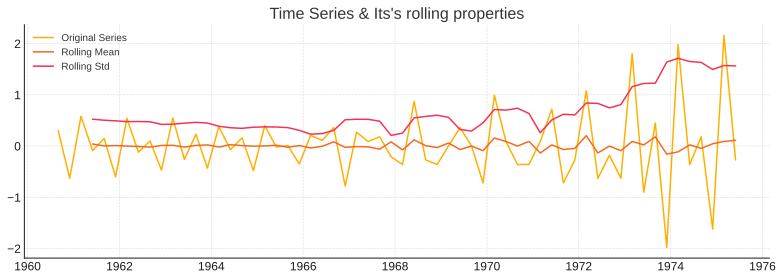

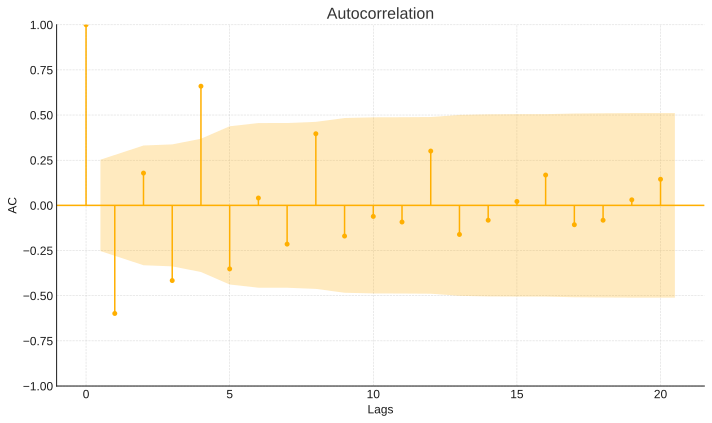

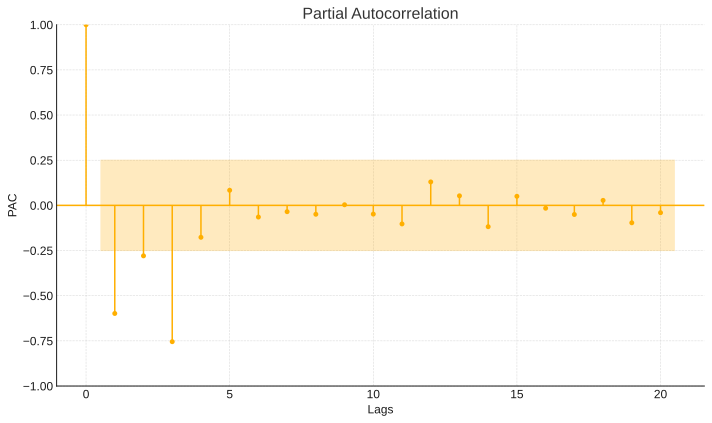

Augmented Dickey-Fuller Test: c
ADF Statistic: -6.6891332184319845
p-value: 4.152422393916324e-09 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -6.577025993137183
p-value: 1.248594231281269e-07 

KPSS Test: c
KPSS Statistic: 0.09732594939779161
p-value: 0.1 

KPSS Test: ct
KPSS Statistic: 0.09732594939779161
p-value: 0.1 

recommended order of seasonal differencing : 
   OCSB recommendation : 1
    nCH recommendation : 0


In [54]:
test_unit_roots(train[2:], 'price_diff_diff', 20)

### Two Regular differences:

- Time series plot: Differenced data has seasonality, trend and heteroscadasticity.
- ACF & PACF: The data is stationary, but seasonal trend is questionable.
- ADF: There is a deterministic trend.
- KPSS: The data is stationary.
- OCSB & CH: The seasonal unit root still needs to be investigated.

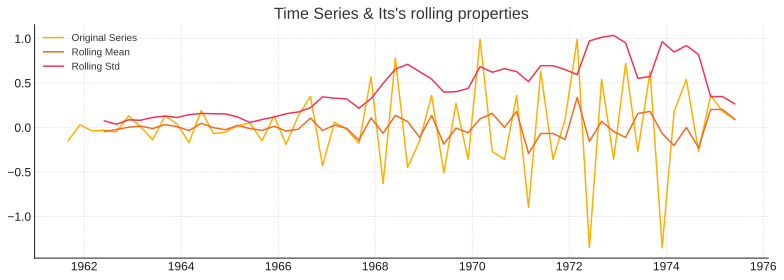

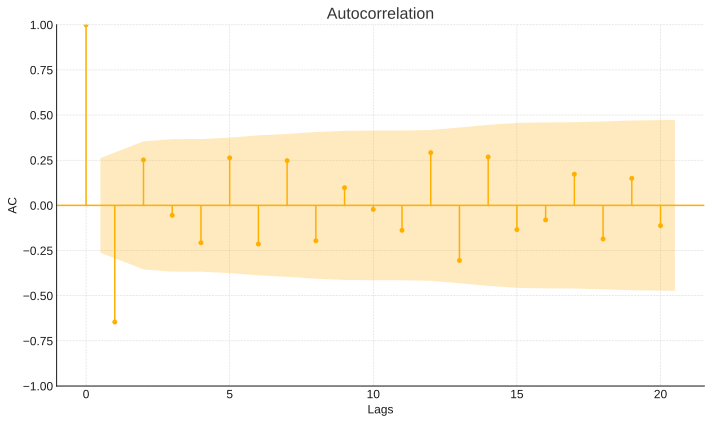

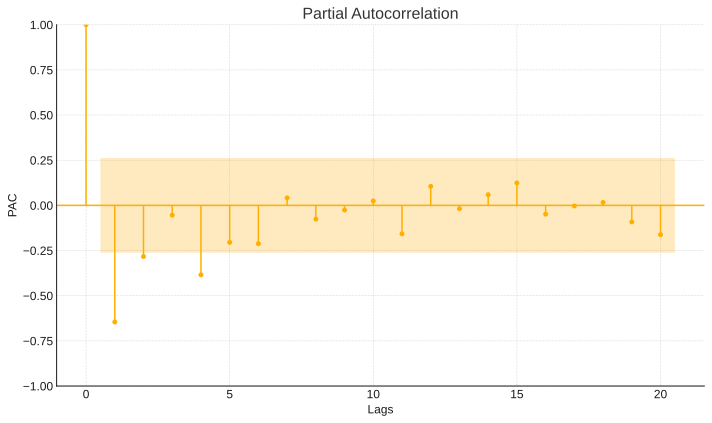

Augmented Dickey-Fuller Test: c
ADF Statistic: -6.704213015807603
p-value: 3.82134286420923e-09 

Augmented Dickey-Fuller Test: ct
ADF Statistic: -6.579236761839166
p-value: 1.2346345112132603e-07 

KPSS Test: c
KPSS Statistic: 0.09156877225125182
p-value: 0.1 

KPSS Test: ct
KPSS Statistic: 0.09156877225125182
p-value: 0.1 

recommended order of seasonal differencing : 
   OCSB recommendation : 0
    nCH recommendation : 0


In [55]:
test_unit_roots(train[6:], 'price_sdiff_diff_diff', 20)

### Seasonal difference with two regular differences:

- Time series plot: Differenced data is seasonality and heteroscadasticity but no trend.
- ACF & PACF: The data is stationary.
- ADF: The data is stationary.
- KPSS: The data is stationary.
- OCSB & CH: no seasonal unit root.

Moving forward we will be using the data that has one seasonal difference and two regular differences.

# Model Selection:

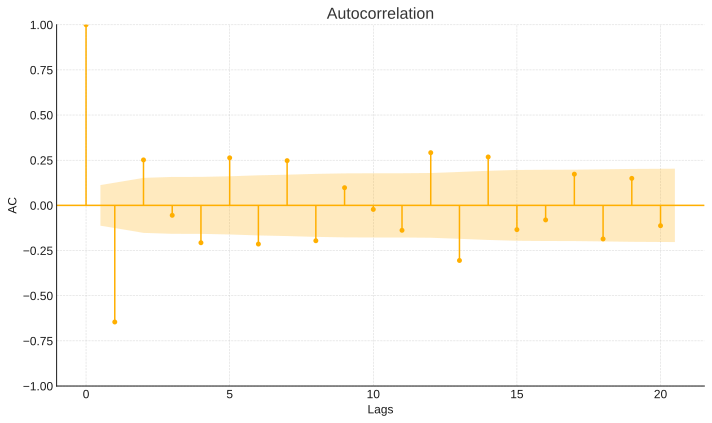

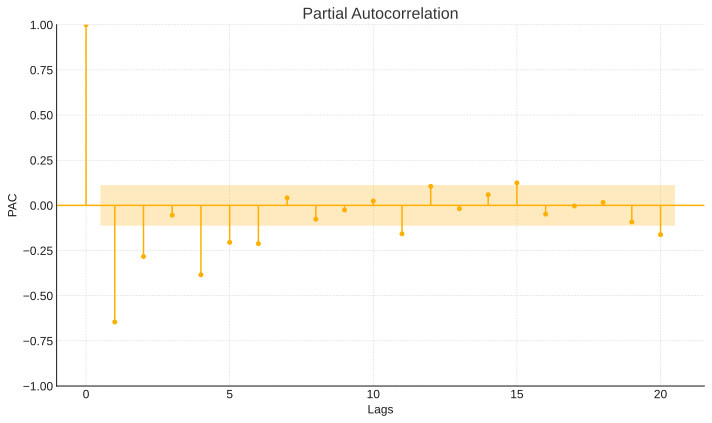

In [59]:
acf_pacf(train[6:], 'price_sdiff_diff_diff', 20, alpha=0.4)

## Possible models from the ACF and PACF plots:

- SARIMA(2,2,1)$*$(1,1,0)$_4$
- SARIMA(3,2,1)$*$(1,1,0)$_4$
- SARIMA(2,2,0)$*$(1,1,0)$_4$
- SARIMA(3,2,0)$*$(1,1,0)$_4$
- SARIMA(2,2,0)$*$(1,1,1)$_4$
- SARIMA(3,2,0)$*$(1,1,1)$_4$

In [62]:
train_model_selection = train.to_pandas().set_index('date')

In [65]:
model_summary(train_model_selection['price'], (2,2,1), (1,1,0,4), "ct")

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   62
Model:             SARIMAX(2, 2, 1)x(1, 1, [], 4)   Log Likelihood                  -6.853
Date:                            Thu, 12 Dec 2024   AIC                             27.707
Time:                                    23:10:59   BIC                             41.884
Sample:                                03-01-1960   HQIC                            33.203
                                     - 06-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.017     -0.122      0.903      -0.035       0.031
drift       7.664e-05      0.000   

In [66]:
model_summary(train_model_selection['price'], (3,2,1), (1,1,0,4), "ct")

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   62
Model:             SARIMAX(3, 2, 1)x(1, 1, [], 4)   Log Likelihood                  -4.642
Date:                            Thu, 12 Dec 2024   AIC                             25.284
Time:                                    23:11:36   BIC                             41.487
Sample:                                03-01-1960   HQIC                            31.566
                                     - 06-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.015      0.114      0.909      -0.027       0.031
drift        -3.4e-05      0.000   

In [68]:
model_summary(train_model_selection['price'], (2,2,0), (1,1,0,4), "ct")

                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                   62
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 4)   Log Likelihood                 -17.062
Date:                           Thu, 12 Dec 2024   AIC                             46.124
Time:                                   23:13:46   BIC                             58.276
Sample:                               03-01-1960   HQIC                            50.835
                                    - 06-01-1975                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0499      0.241     -0.207      0.836      -0.522       0.422
drift          0.0017      0.005      0.337

In [69]:
model_summary(train_model_selection['price'], (3,2,0), (1,1,0,4), "ct")

                                     SARIMAX Results                                     
Dep. Variable:                             price   No. Observations:                   62
Model:             SARIMAX(3, 2, 0)x(1, 1, 0, 4)   Log Likelihood                 -14.930
Date:                           Thu, 12 Dec 2024   AIC                             43.860
Time:                                   23:14:02   BIC                             58.038
Sample:                               03-01-1960   HQIC                            49.357
                                    - 06-01-1975                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0501      0.233     -0.216      0.829      -0.506       0.406
drift          0.0016      0.005      0.338

In [70]:
model_summary(train_model_selection['price'], (2,2,0), (1,1,1,4), "ct")

                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                   62
Model:             SARIMAX(2, 2, 0)x(1, 1, [1], 4)   Log Likelihood                 -16.672
Date:                             Thu, 12 Dec 2024   AIC                             47.343
Time:                                     23:14:47   BIC                             61.521
Sample:                                 03-01-1960   HQIC                            52.840
                                      - 06-01-1975                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0334      0.157     -0.213      0.831      -0.341       0.274
drift          0.0012      

In [71]:
model_summary(train_model_selection['price'], (3,2,0), (1,1,1,4), "ct")

                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                   62
Model:             SARIMAX(3, 2, 0)x(1, 1, [1], 4)   Log Likelihood                 -10.281
Date:                             Thu, 12 Dec 2024   AIC                             36.562
Time:                                     23:15:47   BIC                             52.765
Sample:                                 03-01-1960   HQIC                            42.844
                                      - 06-01-1975                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0150      0.060     -0.252      0.801      -0.132       0.102
drift          0.0005      

## Selected model:

From the IC scores and the how well the model fits from the Ljing-Box and Jarque-Bera tests, the best model is:
    $$\text{SARIMA}(2,2,1)*(1,1,0)_4$$

# Diagnostic Checking:

In [77]:
model = SARIMAX(endog=train_model_selection['price'],
                order=(2,2,1), seasonal_order=(1,1,0,4), trend='ct')
model_fit = model.fit(method='powell', disp=False)

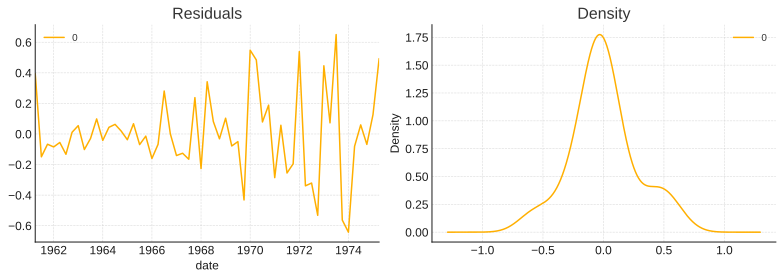

In [78]:
# density plot of residuals
residuals = pd.DataFrame(model_fit.resid)[5:]
fig, ax = plt.subplots(1,2, figsize=(11, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

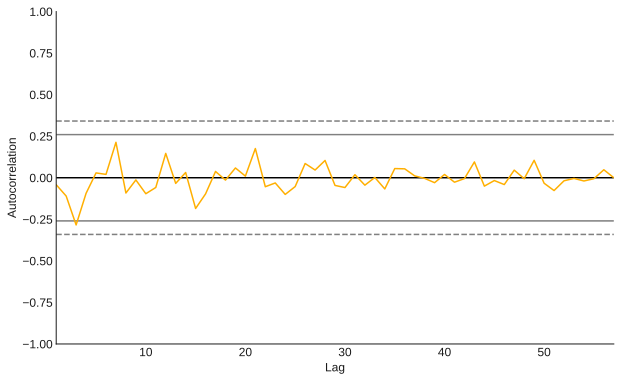

In [79]:
autocorrelation_plot(residuals)

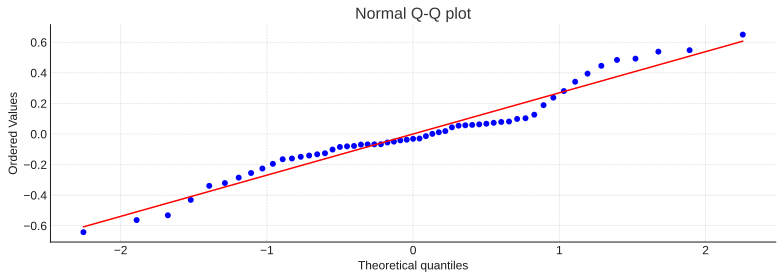

In [81]:
plt.figure(figsize=(11, 4))
stats.probplot(residuals[0], dist="norm", plot=plt)
plt.title('Normal Q-Q plot')
plt.tight_layout()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

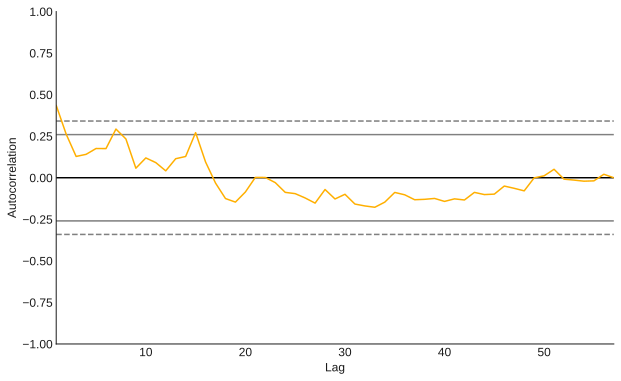

In [82]:
autocorrelation_plot(residuals**2)

In [83]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                   62
Model:             SARIMAX(2, 2, 1)x(1, 1, [], 4)   Log Likelihood                  -6.853
Date:                            Thu, 12 Dec 2024   AIC                             27.707
Time:                                    23:26:58   BIC                             41.884
Sample:                                03-01-1960   HQIC                            33.203
                                     - 06-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.017     -0.122      0.903      -0.035       0.031
drift       7.664e-05      0.000      0.171      0.864      -0.001       0.001
ar.L1         -0.3782      0.147     -2.571      0.010      -0.667      -0.090
ar.L2         -0.0393      0.137     -0.287      0.774      -0.309       0.230
ma.L1         -1.0000    535.997     -0.002      0.999   -1051.535    1049.535
ar.S.L4       -0.3592      0.141     -2.553      0.011      -0.635      -0.083
sigma2         0.0672     36.011      0.002      0.999     -70.513      70.647
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.81   Prob(JB):                         0.49
Heteroskedasticity (H):              28.87   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
lm_result = acorr_lm(residuals, period=5)

print('Lagrange Multiplier Test:')
print(f'LM Statistic: {lm_result[0]}')
print(f'p-value: {lm_result[1]} \n')

Lagrange Multiplier Test:
LM Statistic: 9.6866320418111
p-value: 0.468402805556267 



In [87]:
arch_test = het_arch(residuals)
print('ARCH Test:')
print(f'LM Statistic: {arch_test[0]},\np-value: {arch_test[1]}')

ARCH Test:
LM Statistic: 20.991288502299316,
p-value: 0.02115439341781848


## Interpretation:

- Autocorrelation: From the Ljung-Box statistic, Lagrange Multiplier test, ACF and PACF the residuals don't have autocorrelation.
- Distribution: From the Q-Q plot, histogram and the Jarque-Bera statistic it is clear that the residuals are normally distributed.
- Heteroscedasticity: From the line graph and the ARCH Engle's test we can say that the data has heteroscedasticity.

# Forecasting:

In [125]:
sarima = SARIMAX(endog=train.to_pandas().set_index('date')['price'],
                order=(2,2,1), seasonal_order=(1,1,0,4), trend='ct')
sarima_fit = sarima.fit(method='powell', disp=False)

In [136]:
output = sarima_fit.get_forecast(steps=8)
output = output.summary_frame()
predictions = output['mean']

In [138]:
sarima_fitvals = sarima_fit.fittedvalues

In [148]:
output

price,mean,mean_se,mean_ci_lower,mean_ci_upper
1979-03-01,12.993426,0.421317,12.167659,13.819193
1979-06-01,13.366808,0.468530,12.448507,14.285110
1979-09-01,12.988136,0.514202,11.980318,13.995954
1979-12-01,10.347406,0.581890,9.206923,11.487890
1980-03-01,14.264773,0.826725,12.644423,15.885124
1980-06-01,14.555377,0.925233,12.741954,16.368800
1980-09-01,14.280550,1.021125,12.279182,16.281917
1980-12-01,11.522660,1.128316,9.311201,13.734118


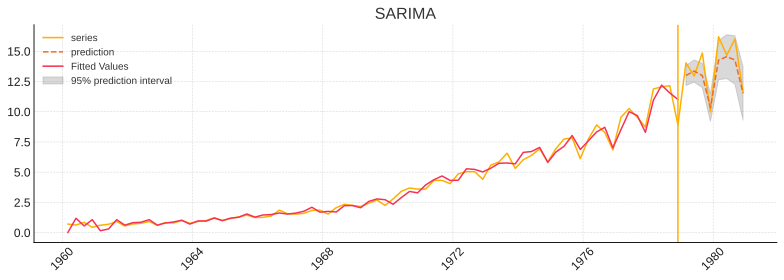

In [151]:
plt.figure(figsize=(11,4))
plt.plot(jj_ts['date'], jj_ts['price'], label='series')
plt.plot(predictions.index, predictions, label='prediction', linestyle="--")
plt.plot(sarima_fitvals, label='Fitted Values')
plt.axvline(train['date'][-1])
plt.fill_between(
    test['date'],
    output['mean_ci_lower'],  # Lower bound
    output['mean_ci_upper'],  # Upper bound
    color="gray",
    alpha=0.3,
    label="95% prediction interval"
)
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.title('SARIMA')
plt.tight_layout()
plt.show()

In [142]:
# evaluate forecasts
sarima_score = math.sqrt(mean_squared_error(predictions, test['price']))
print('Test RMSE: %.3f' %sarima_score)

Test RMSE: 1.207


### Comparing RMSE score:
    
    - SARIMA: 1.207

The predictions are quite close to the actual values showing a very good fit, similarly the RMSE score tells the same thing. Looks like the model captured the seasonality.